<center><h1>Image preprocessing demo</h1></center>

## Imports

In [10]:
import os
import glob

import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from skimage import measure
from scipy.ndimage import distance_transform_edt

from hep2_classification.presentation import display_grid, ImagePlotter, HistogramPlotter, LayerPlotter, RANDOM_CMAP
from hep2_classification.preprocessing import preprocess

## Settings

In [2]:
paths = list(sorted(glob.glob('data/samples/*.*')))
titles = [os.path.splitext(os.path.basename(p))[0] for p in paths]

## Load data

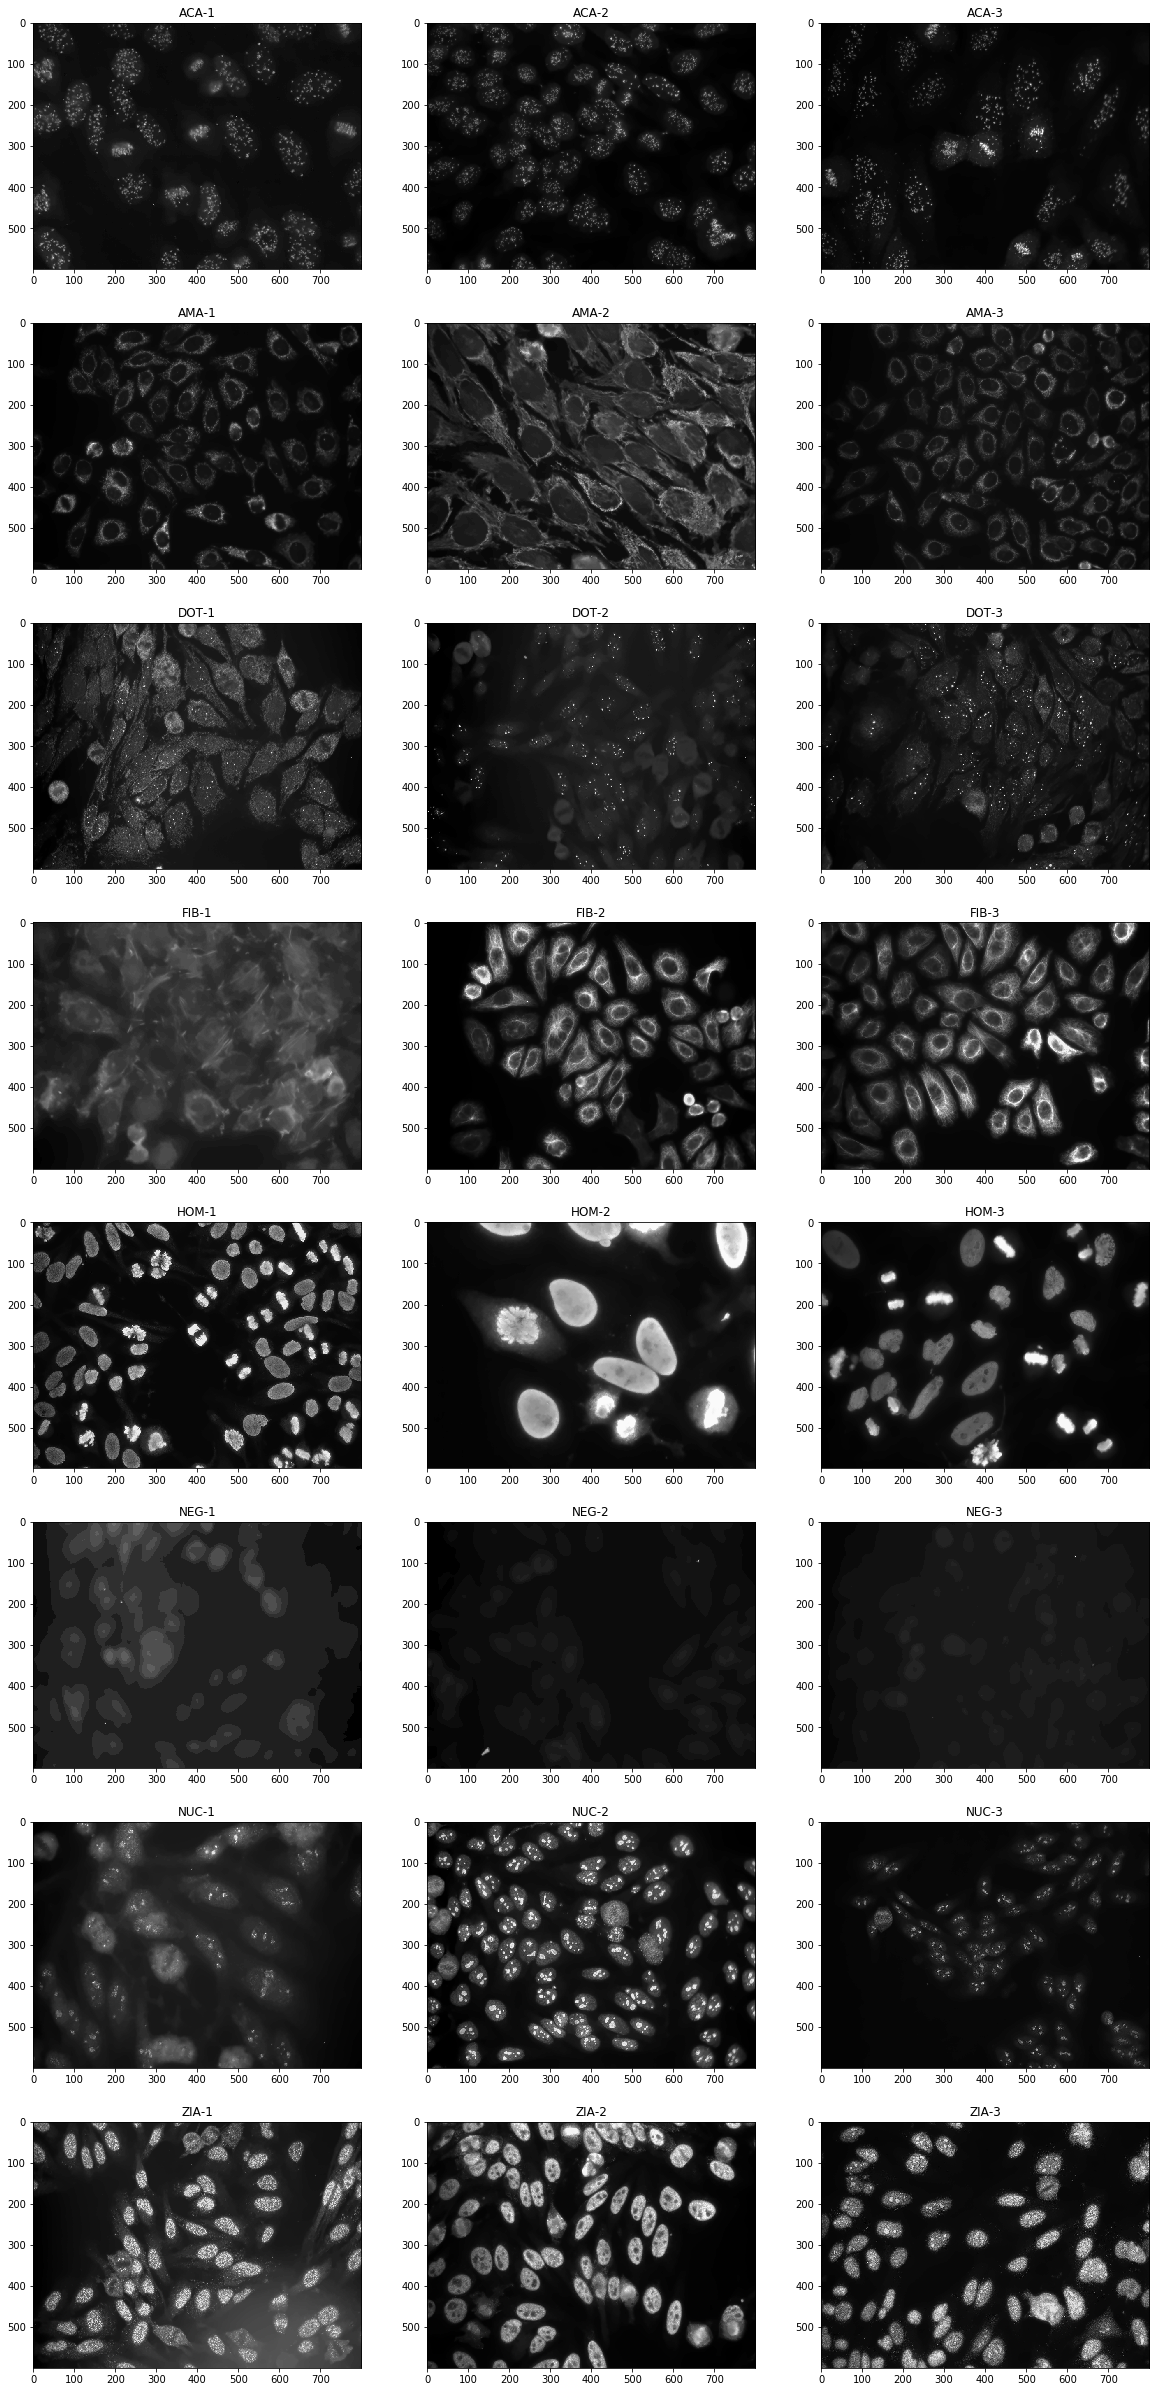

In [3]:
imgs = [preprocess(cv.imread(p)) for p in paths]
display_grid(imgs, ImagePlotter(), titles)

---
## Segmentation steps
### Adaptive kernel

In [24]:
def apply_adaptive_kernel(img, kernel, min_avg=100, max_avg=120, min_delta=400, max_delta=2200):
    
    while max_delta - min_delta > 50:
        avg_delta = (min_delta + max_delta) / 2.0
        kerneled = cv.filter2D(img, -1, kernel, delta=-avg_delta)
        avg = np.average(kerneled)
        
        if avg > max_avg:
            min_delta = avg_delta
        elif avg < min_avg:
            max_delta = avg_delta
        else:
            return kerneled
            
    raise ValueError('Failed to find kernel in given delta range')

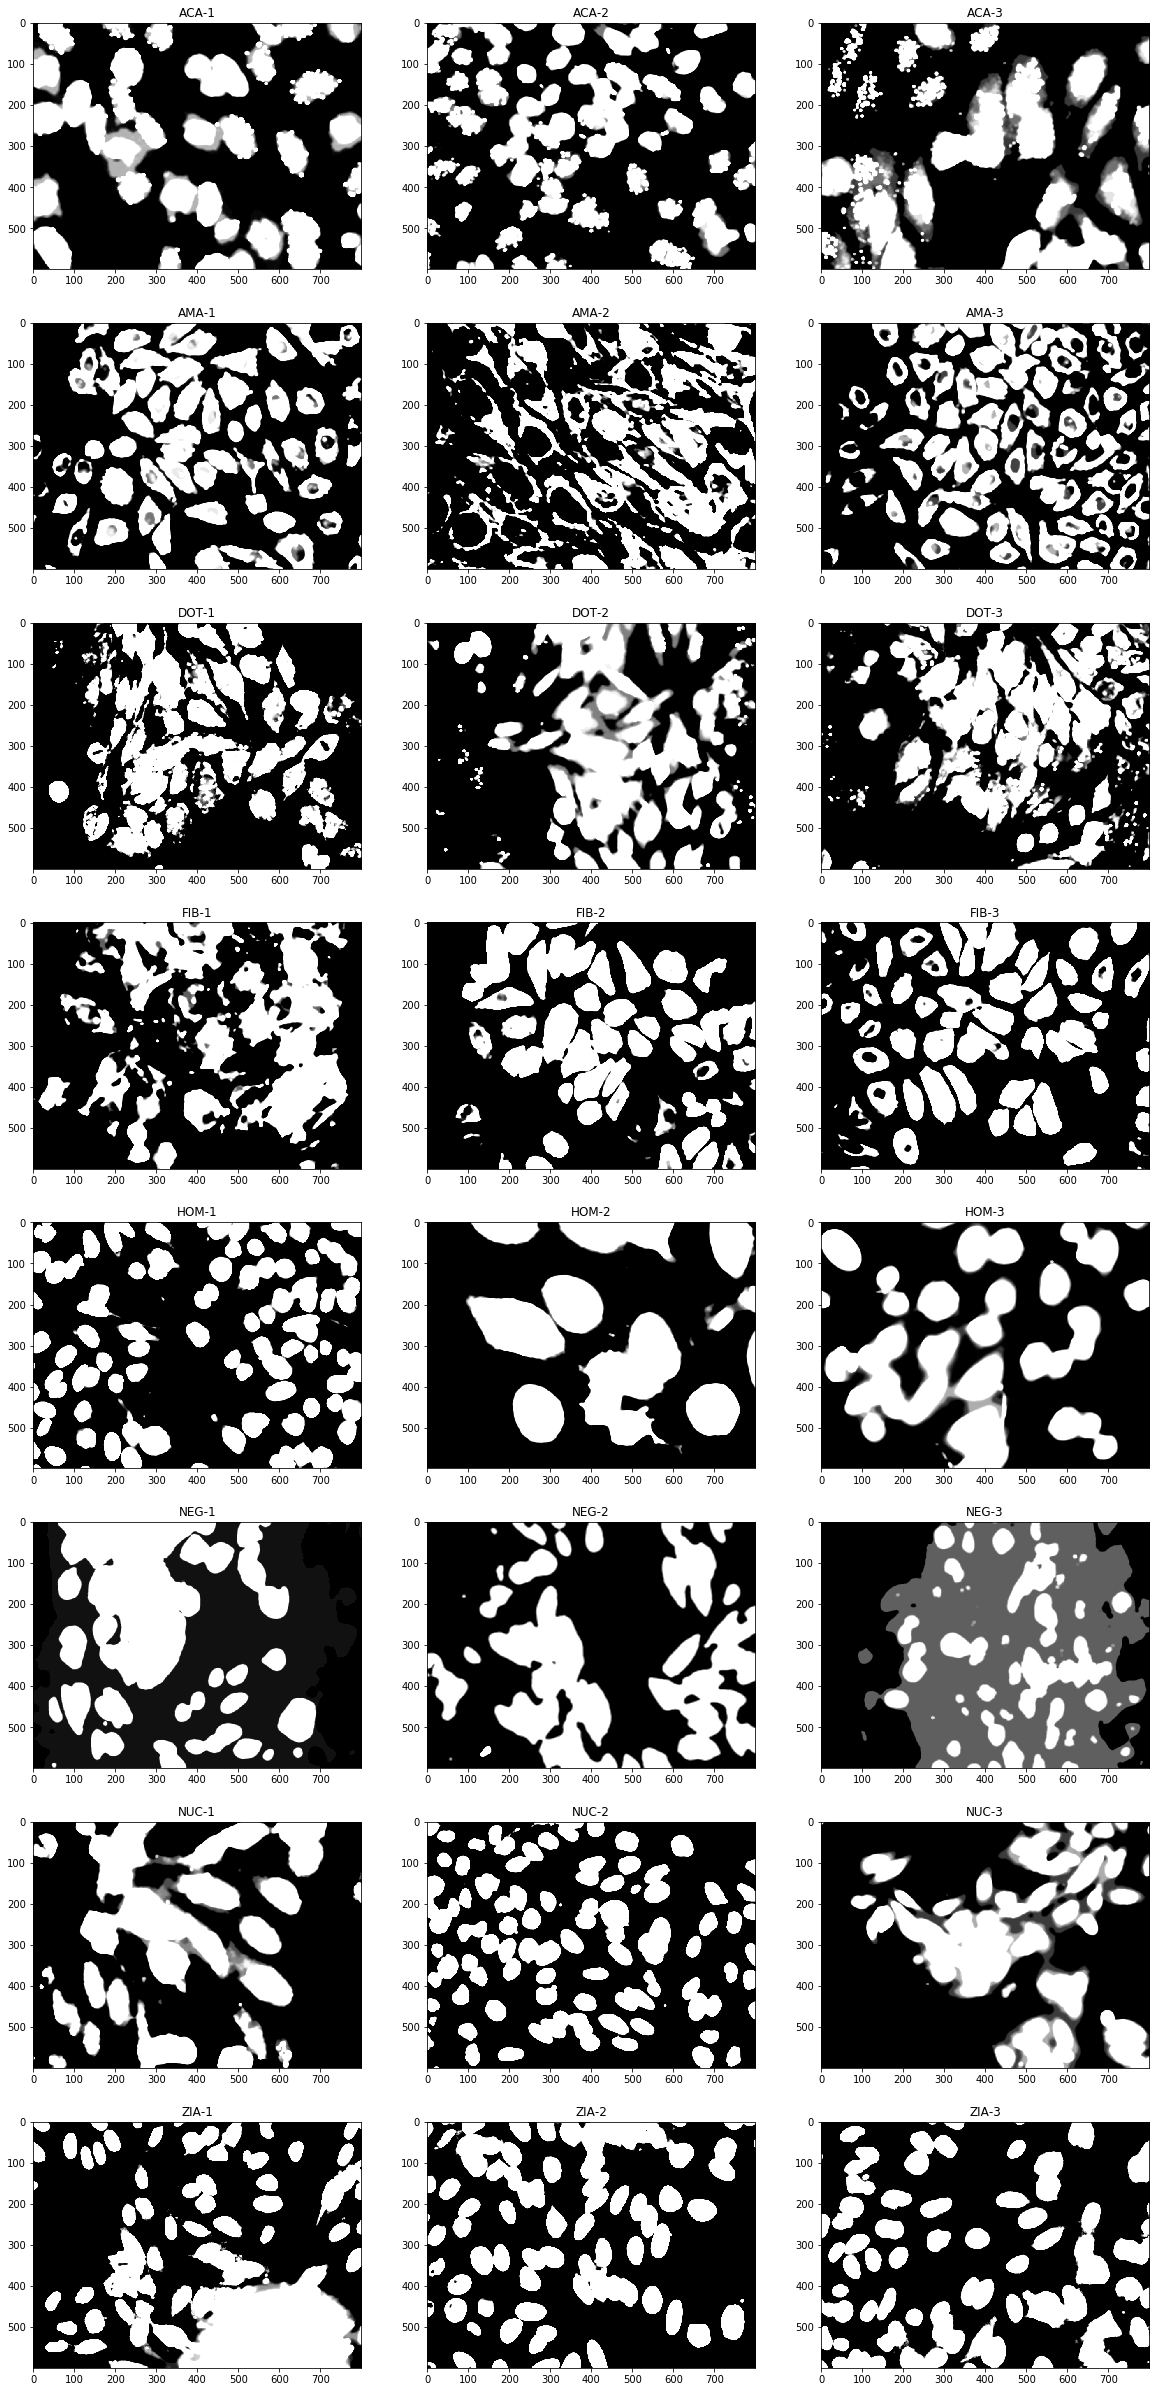

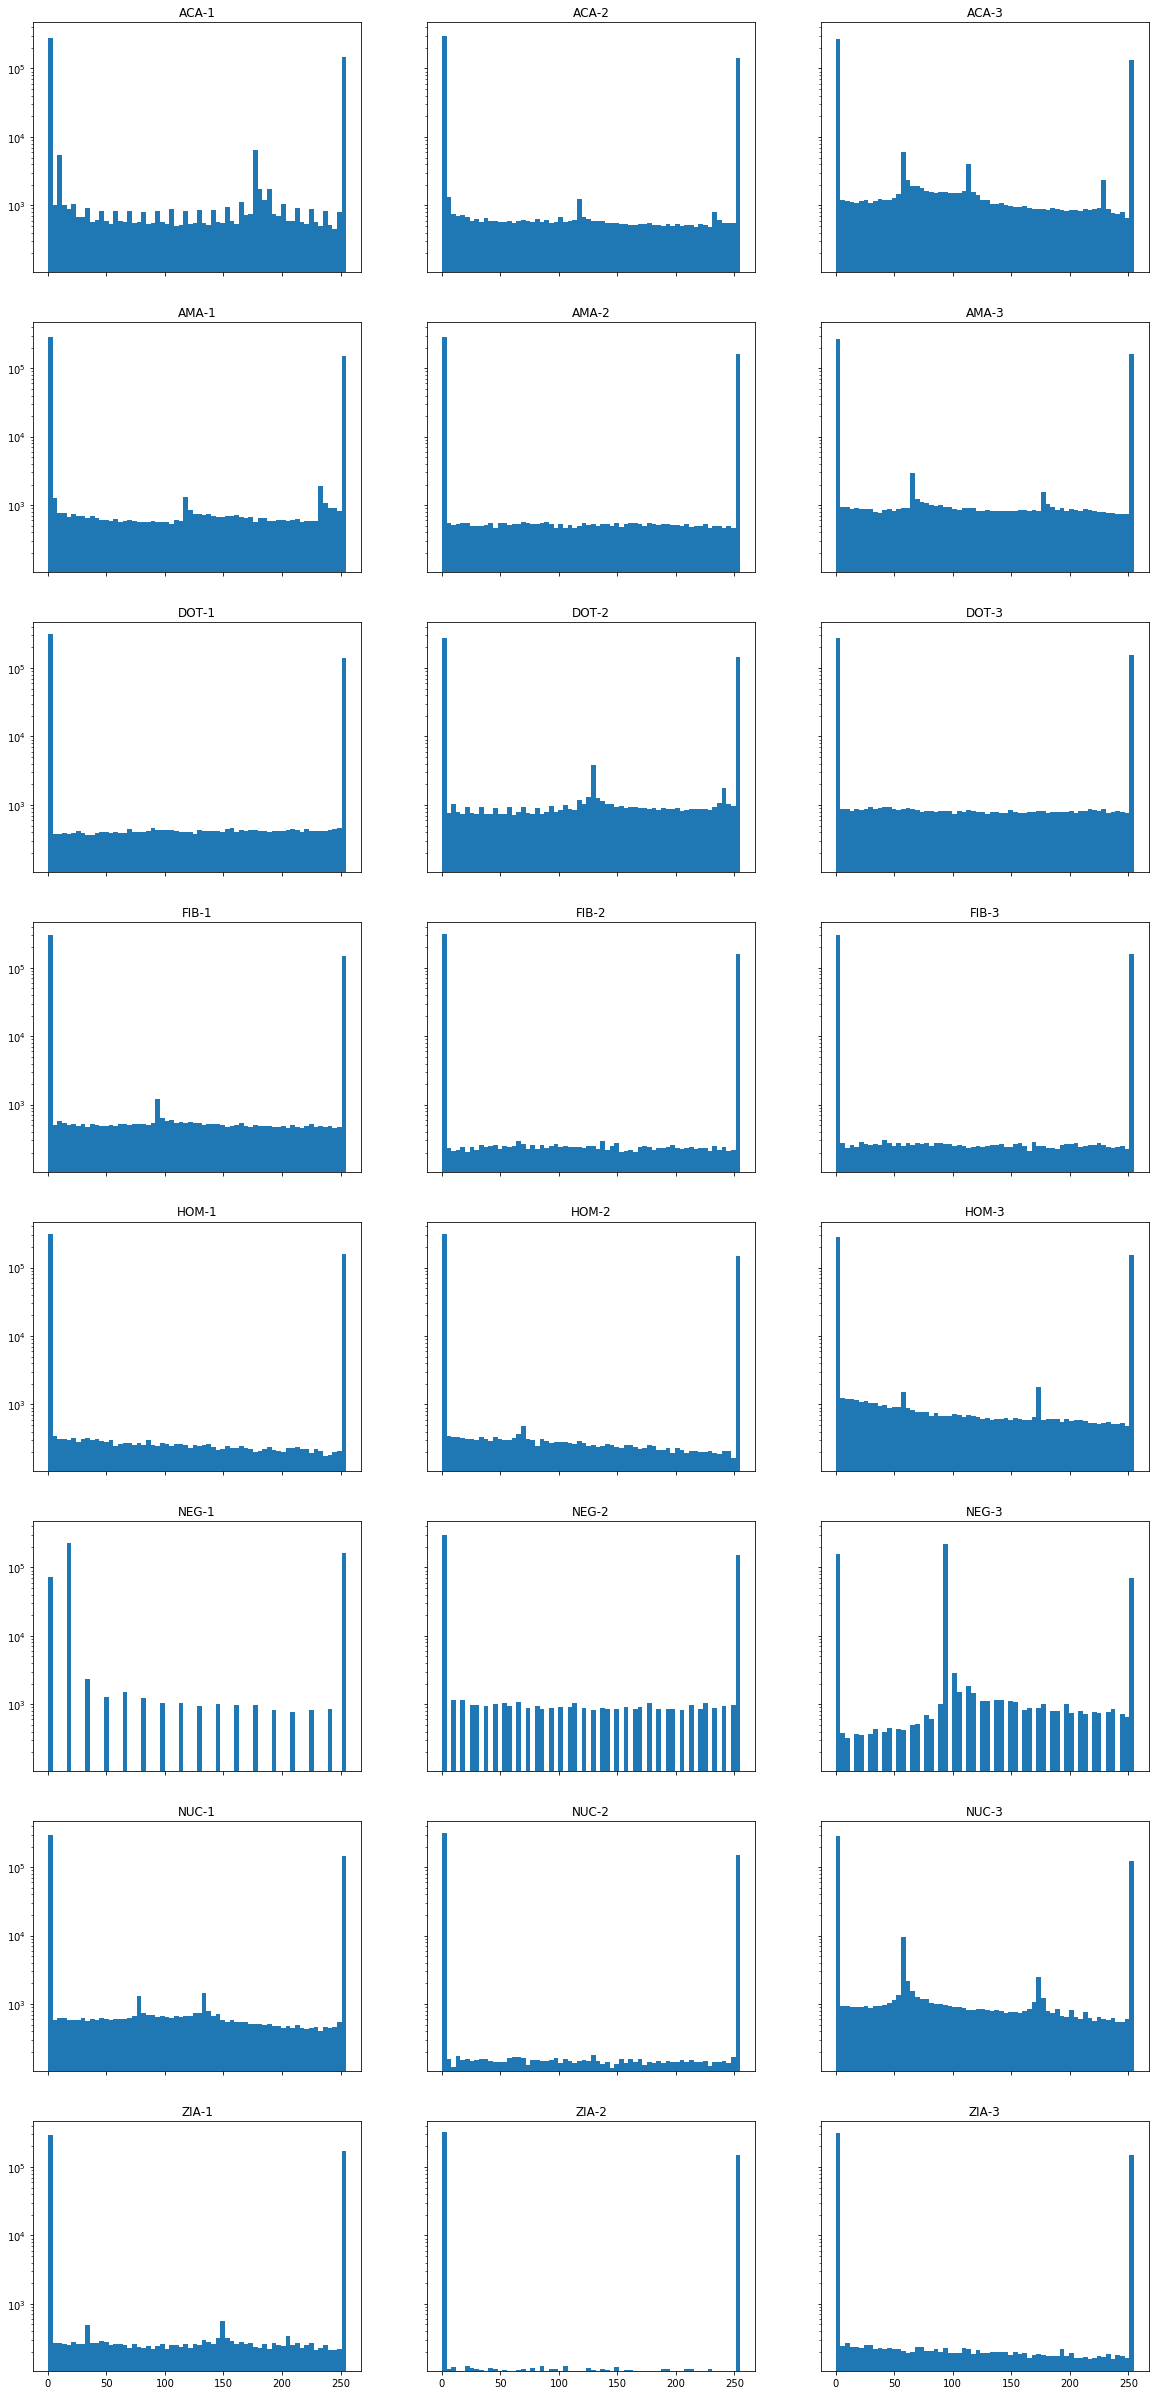

In [5]:
kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (9,9))
imgs_kernel = [apply_adaptive_kernel(img, kernel, min_avg=80, max_avg=100, max_delta=4000) for img in imgs]
# imgs_kernel = [cv.filter2D(img, -1, kernel, delta=-1000) for img in imgs]
display_grid(imgs_kernel, ImagePlotter(), titles)
display_grid(imgs_kernel, HistogramPlotter(), titles, sharey=True, sharex=True)

### Threshold

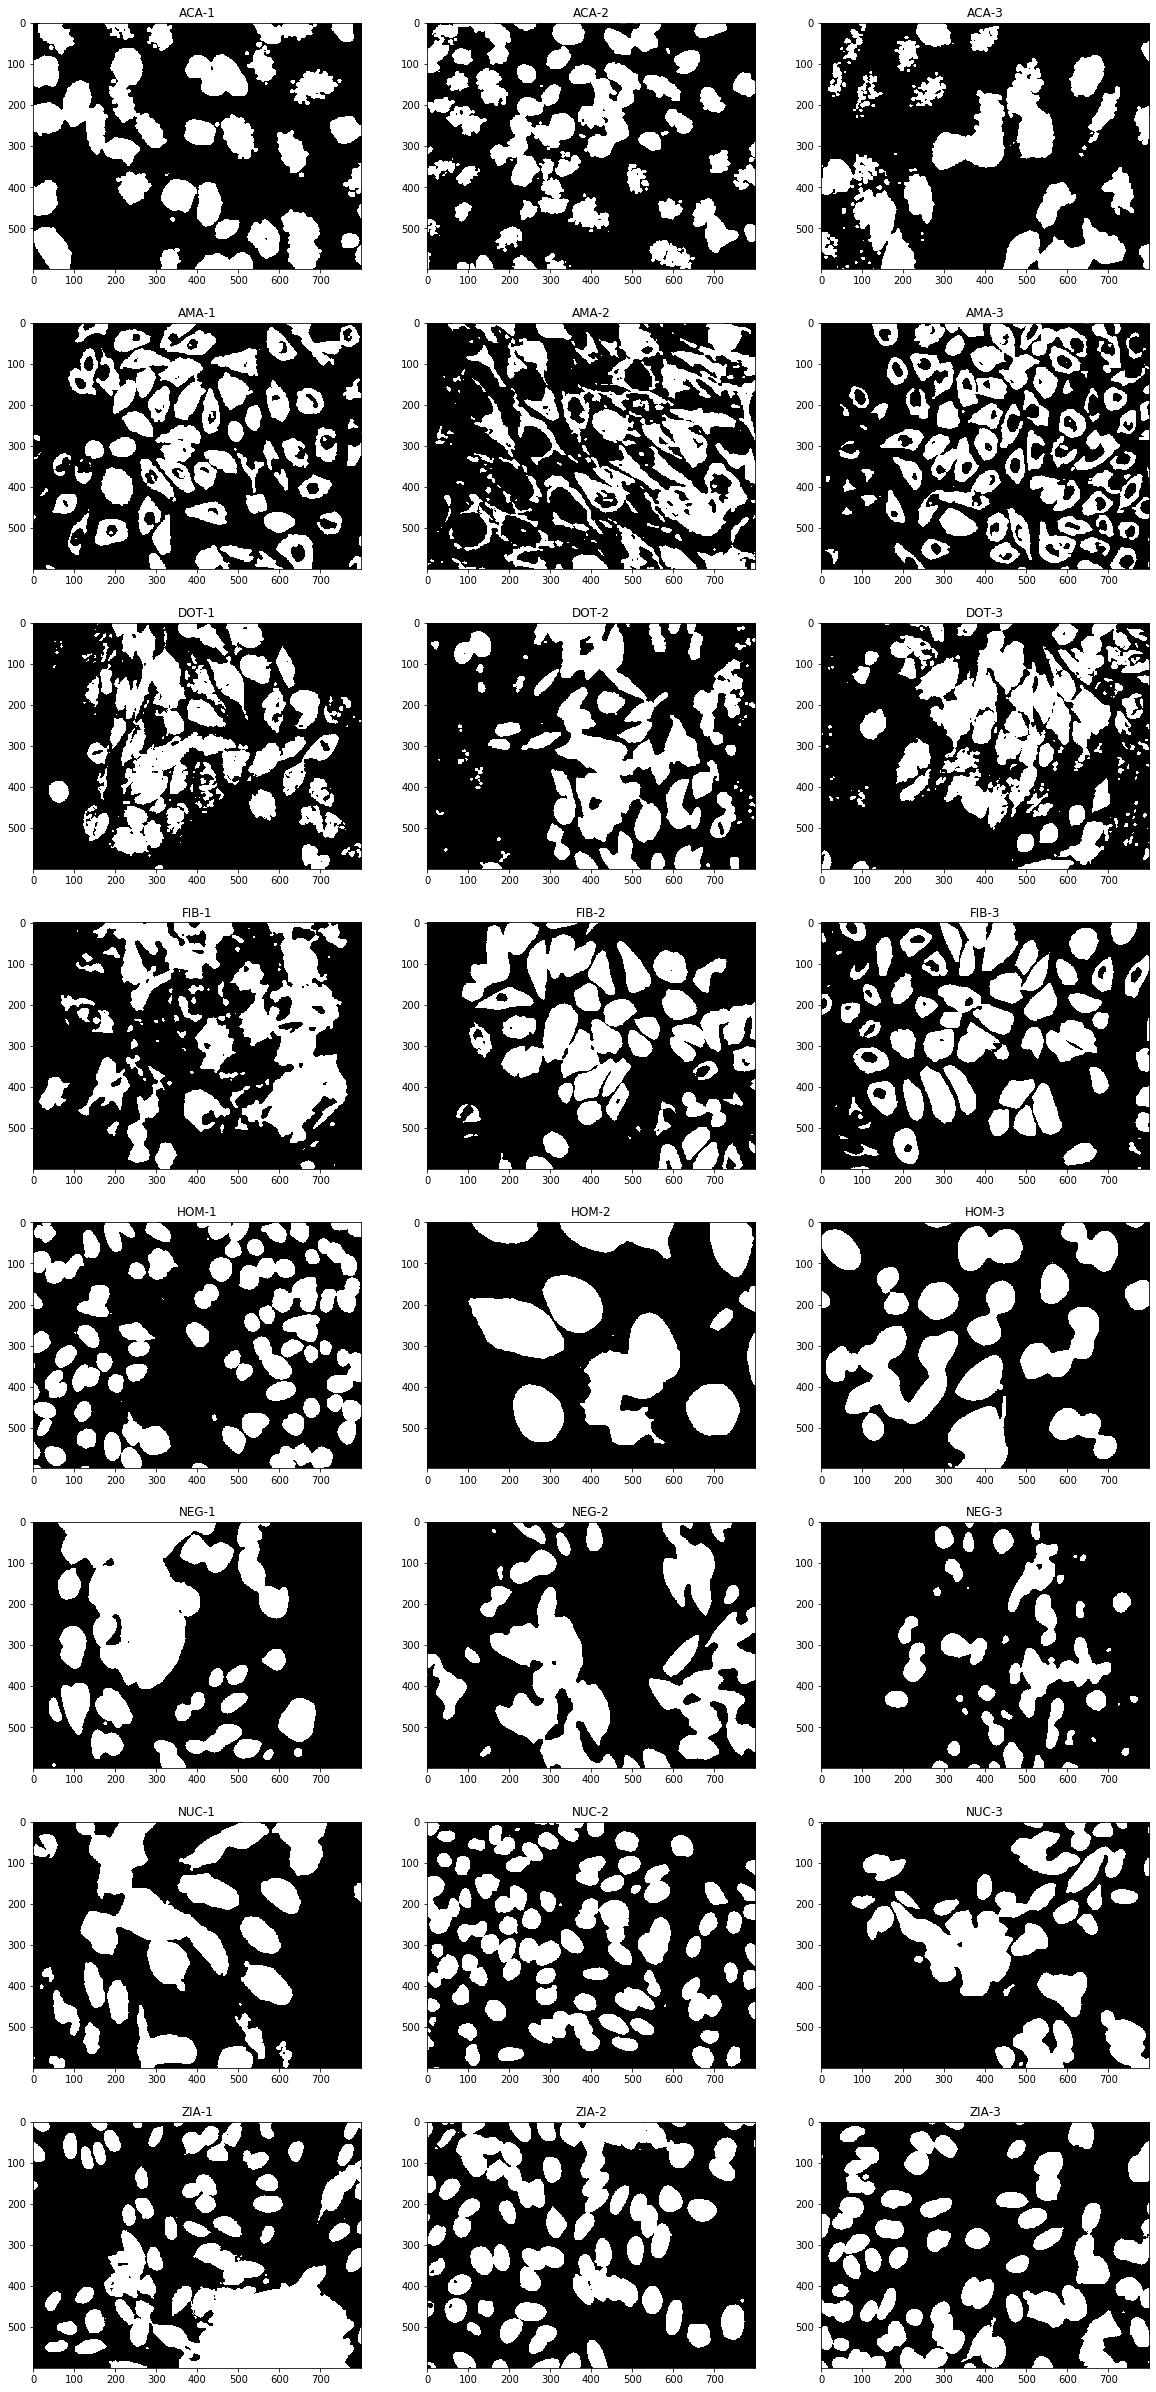

In [6]:
threshold = 240
imgs_threshold = [(img > threshold) for img in imgs_kernel]
display_grid(imgs_threshold, ImagePlotter(), titles)

### Morphological closing 

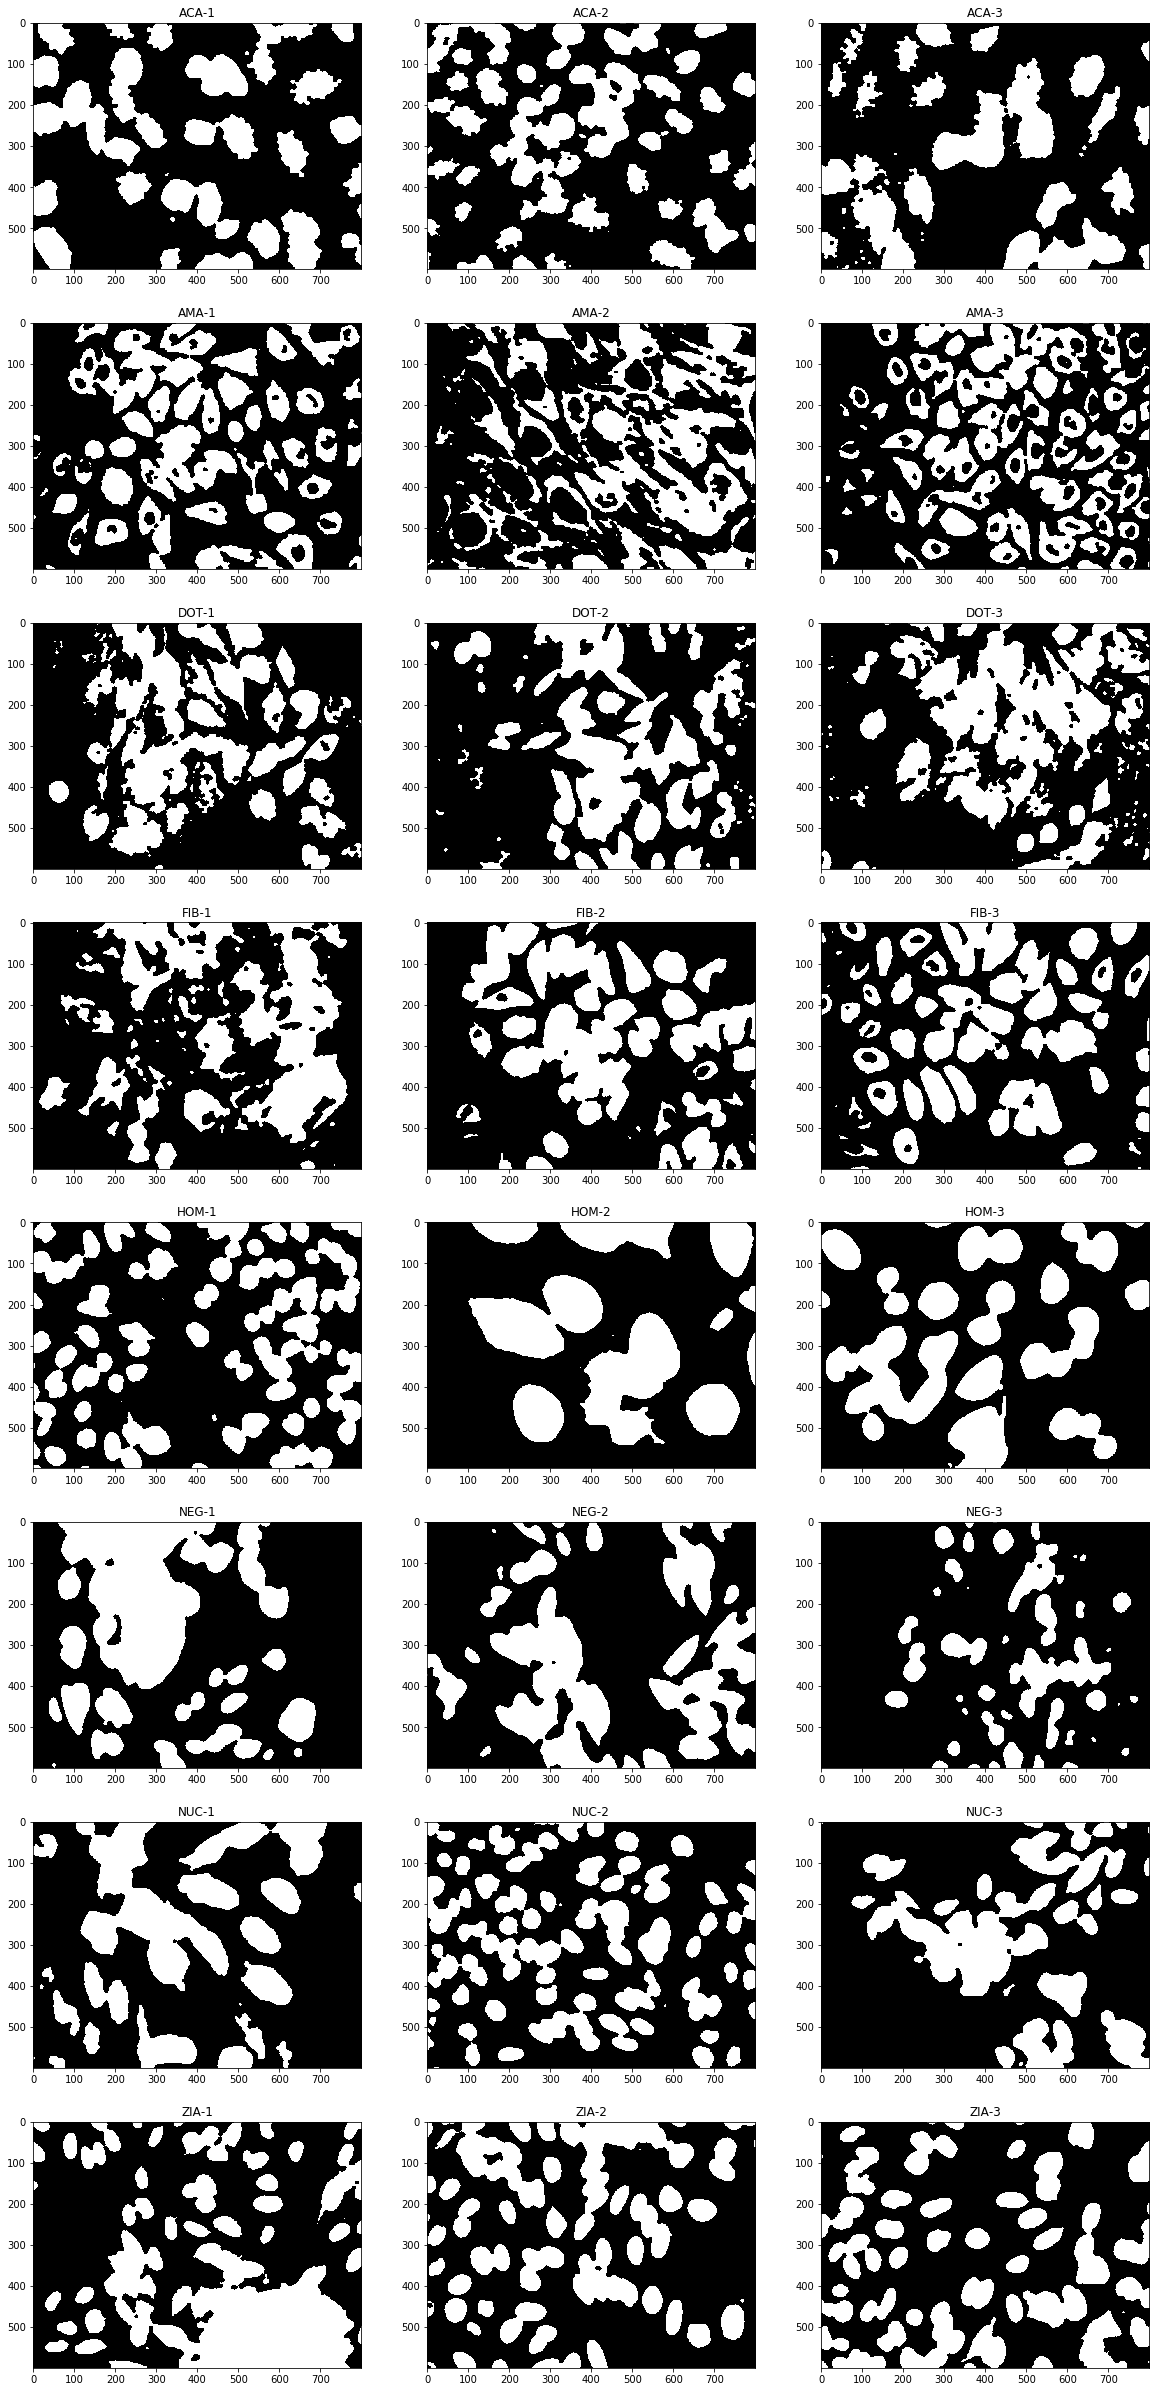

In [19]:
imgs_morph = [cv.morphologyEx(img.astype('uint8'), cv.MORPH_CLOSE, kernel) for img in imgs_threshold]
display_grid(imgs_morph, ImagePlotter(), titles)

### Labels

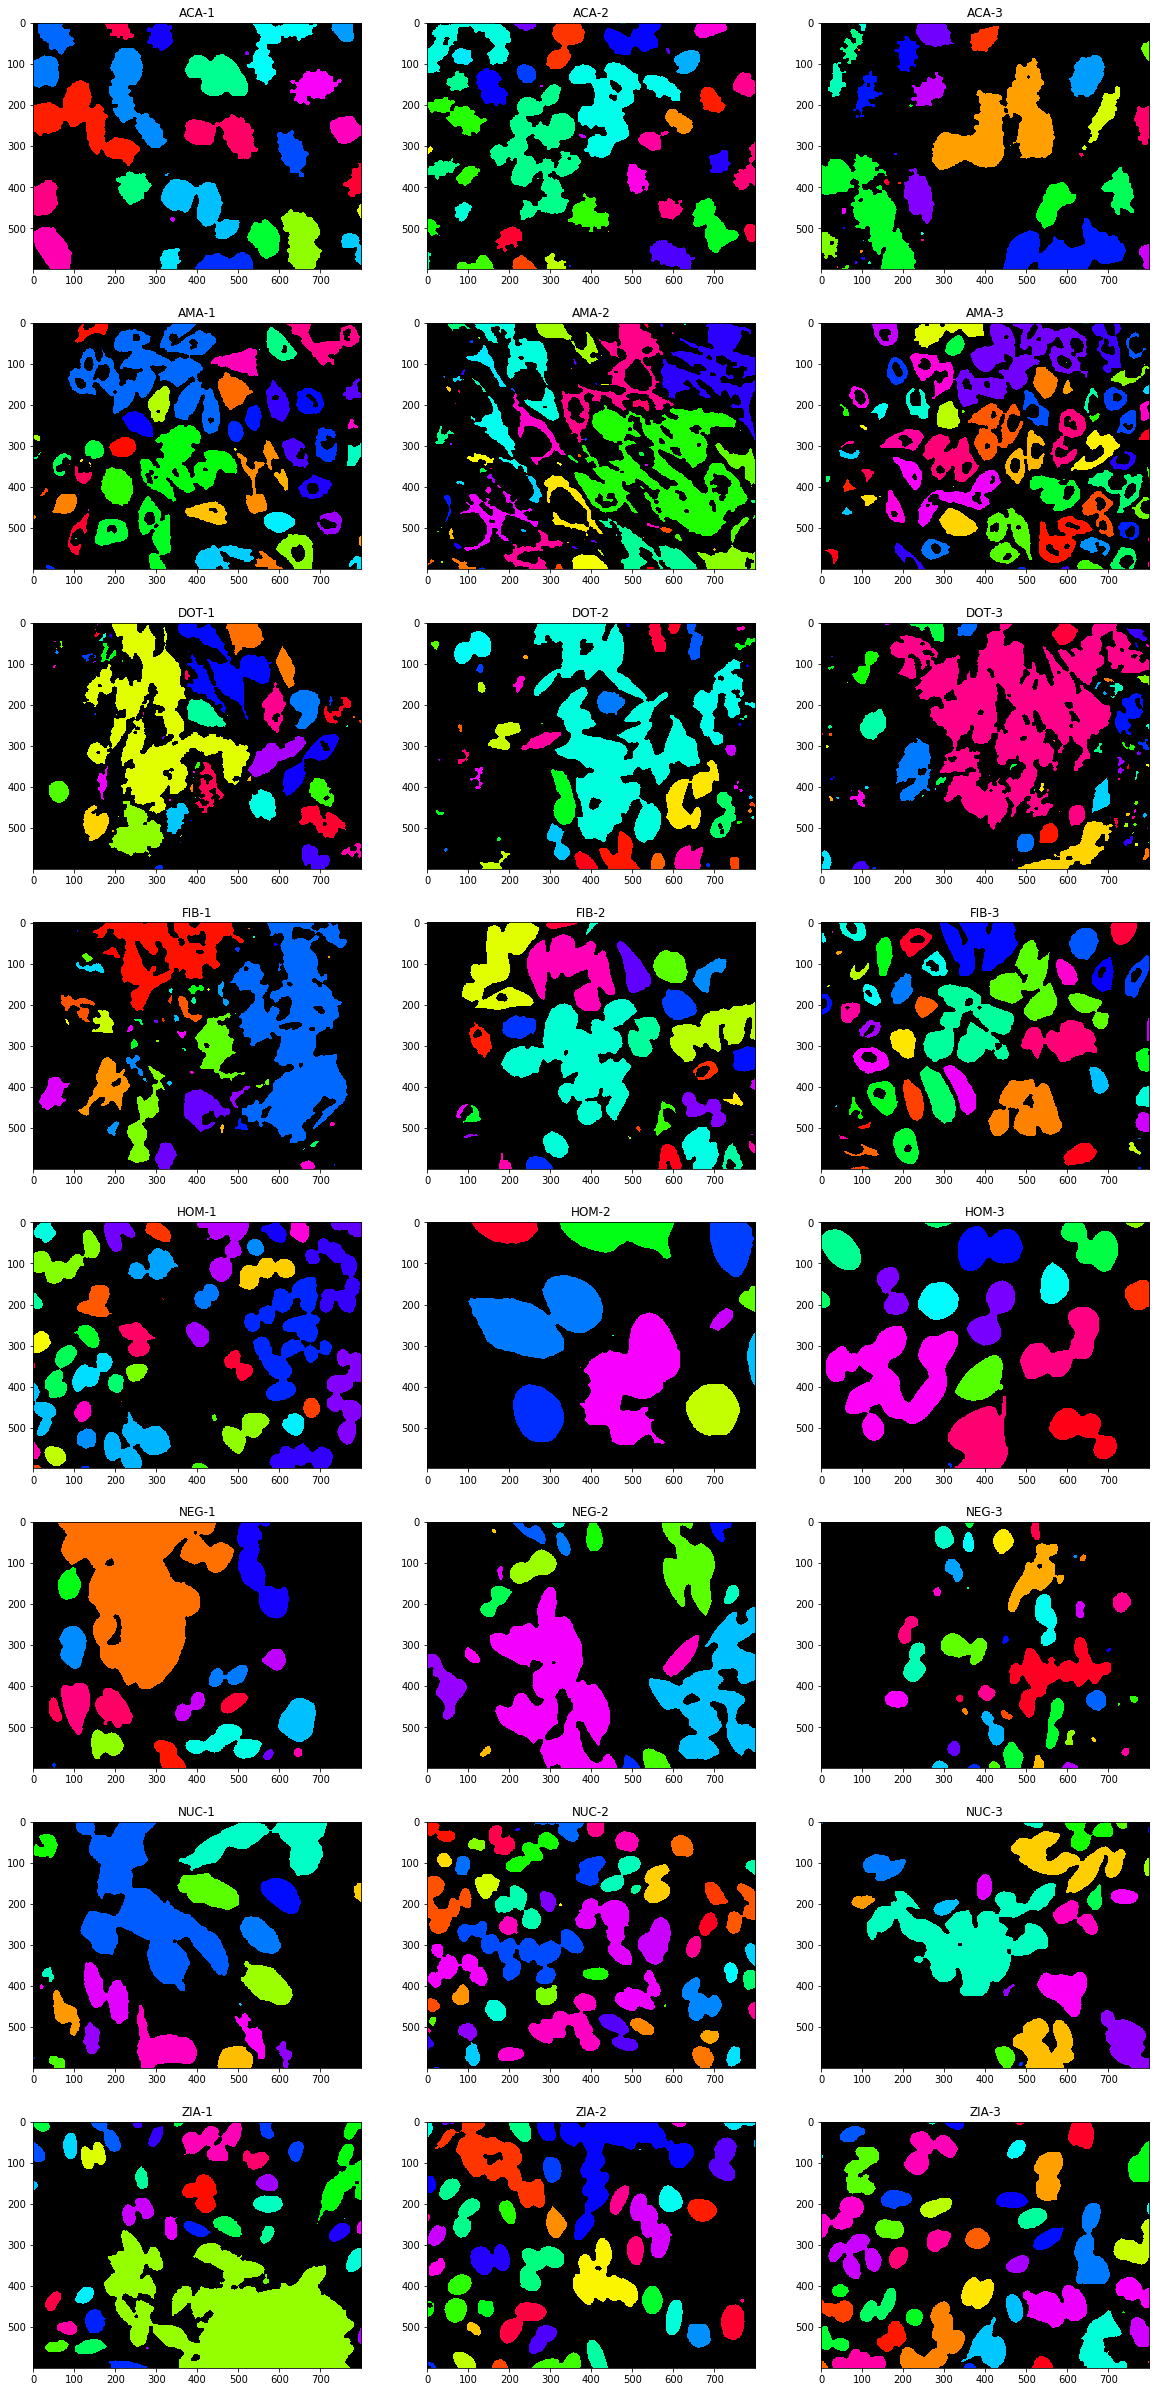

In [22]:
imgs_labeled = [measure.label(img) for img in imgs_morph]
display_grid(imgs_labeled, ImagePlotter(cmap=RANDOM_CMAP), titles)

### Distance transform

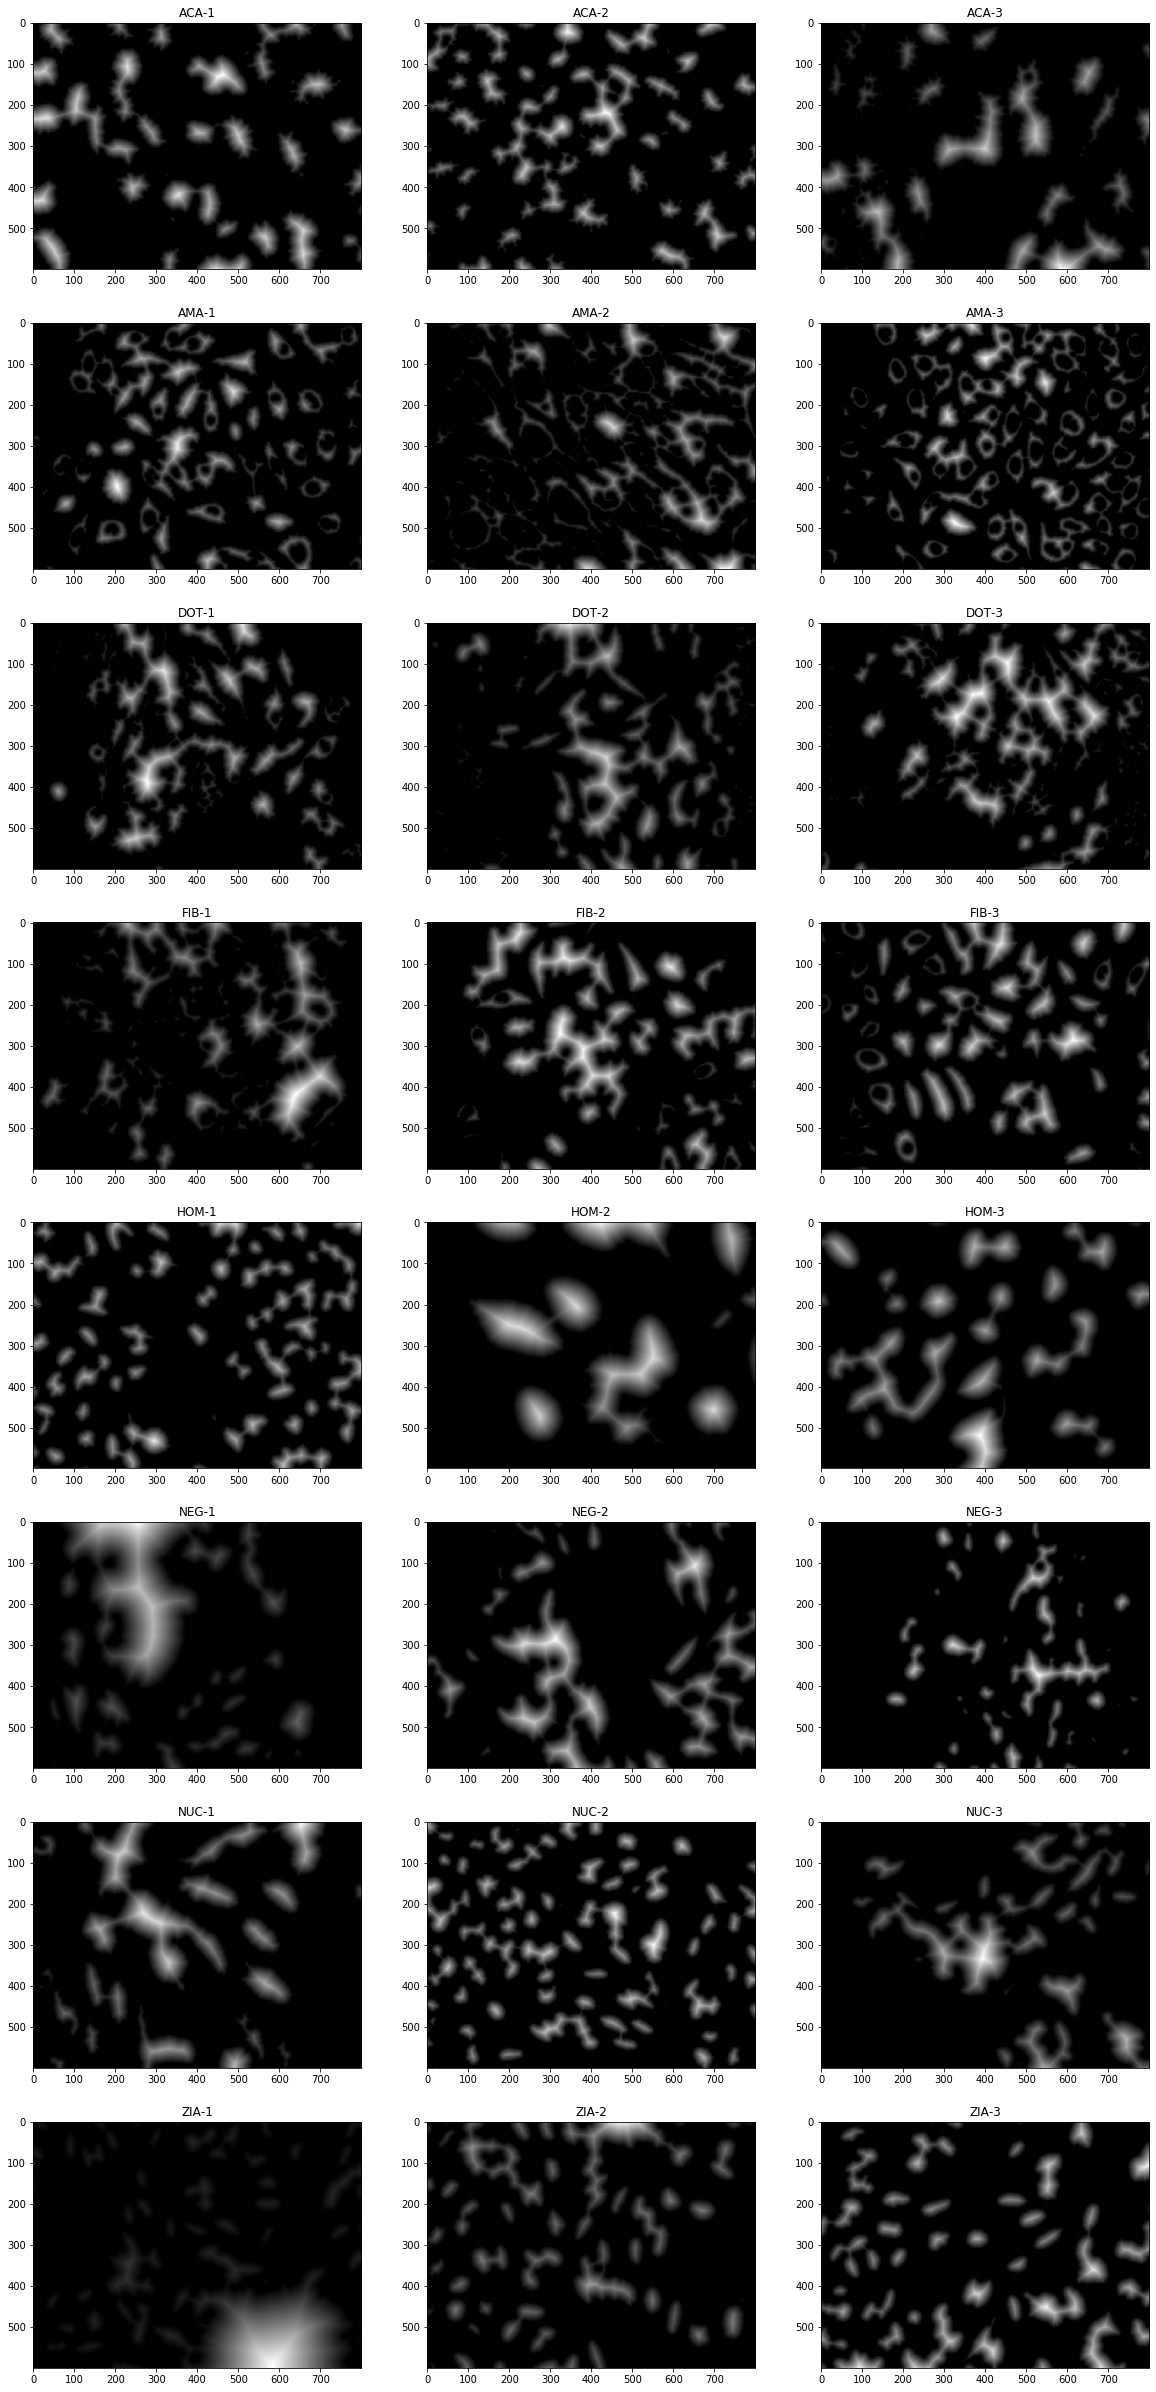

In [25]:
imgs_dists = [distance_transform_edt(img > 0) for img in imgs_labeled]
display_grid(imgs_dists, ImagePlotter(), titles)